# Full pipeline one step at a time

In [1]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from DLC_for_WBFM.utils.feature_detection.utils_features import *
from DLC_for_WBFM.utils.feature_detection.utils_tracklets import *
from DLC_for_WBFM.utils.feature_detection.utils_detection import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import *


In [110]:
# Get the 3d bigtiff folder
bigtiff_folder = r'D:\More-stabilized-wbfm'

btf_fname_red = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\test2020-10-22_16-15-20_test4-channel-0-pco_camera1bigtiff.btf'
btf_fname_red = os.path.join(bigtiff_folder, btf_fname_red)

# Actually import
import_opt = {'num_slices':33, 'alpha':0.15}

dat0_vid = get_single_volume(btf_fname_red, 15, **import_opt)
dat1_vid = get_single_volume(btf_fname_red, 30, **import_opt)

## First, single-volume segmentation

In [111]:
opt = {'num_slices':33, 'alpha':1.0}
# Build point clouds for each plane
all_keypoints_pcs0 = build_point_clouds_for_volume(dat0_vid, **import_opt)
all_icp0 = build_correspondence_icp(all_keypoints_pcs0)

all_keypoints_pcs1 = build_point_clouds_for_volume(dat0_vid, **import_opt)
all_icp1 = build_correspondence_icp(all_keypoints_pcs1)

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


In [112]:
all_neurons = [k.points for k in all_keypoints_pcs0]
all_matches = [m.correspondence_set for m in all_icp0]
clust_df0 = build_tracklets_from_matches(all_neurons, all_matches)

all_neurons = [k.points for k in all_keypoints_pcs1]
all_matches = [m.correspondence_set for m in all_icp1]
clust_df1 = build_tracklets_from_matches(all_neurons, all_matches)

In [114]:
# Visualize
# Build full point cloud

full_pc = o3d.geometry.PointCloud()
for pc in all_keypoints_pcs0:
    full_pc = full_pc + pc
full_pc.paint_uniform_color([0.5,0.5,0.5])

visualize_clusters_from_dataframe(full_pc, clust_df0)

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.12156863, 0.46666667, 0.70588235],
       [0.        , 0.        , 0.        ],
       [0.12156863, 0.46666667, 0.70588235],
       [0.        , 0.        , 0.        ],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.        , 0.        , 0.        ],
       [1.        , 0.49803922, 0.05490196],
       [0.68235294, 0.78039216, 0.90980392],
       [1.        , 0.49803922, 0.05490196],
       [1.        , 0.49803922, 0.05490196],
       [0.68235294, 0.78039216, 0.90980392],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.68235294, 0.78039216, 0.90980392],
       [1.

In [30]:
# Visualize
# Build full point cloud

full_pc = o3d.geometry.PointCloud()
for pc in all_keypoints_pcs1:
    full_pc = full_pc + pc
full_pc.paint_uniform_color([0.5,0.5,0.5])

visualize_clusters_from_dataframe(full_pc, clust_df1)

## Next, matching

In [115]:
opt = {'num_slices':33, 'alpha':1.0, 'verbose':1}
neurons0, df0, icp0, pcs0 = detect_neurons_using_ICP(dat0_vid, **opt)
neurons1, df1, icp1, pcs1 = detect_neurons_using_ICP(dat1_vid, **opt)

Building pairwise correspondence...
Building clusters...
Finished ID'ing neurons
Building pairwise correspondence...
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Building clusters...
Finished ID'ing neurons


In [116]:
all_features0, all_features1, kp0, kp1 = build_features_on_all_planes(dat0_vid,dat1_vid,
                                                                      verbose=1,
                                                                      matches_to_keep=0.8,
                                                                      num_features_per_plane=10000,
                                                                      detect_keypoints=True,
                                                                      kp0=neurons0,
                                                                      kp1=neurons1)

In [117]:
all_matches, f2n, all_conf = match_centroids_using_tree(np.array(neurons0), 
                               np.array(neurons1), 
                               all_features0, 
                               all_features1,
                               radius=8,
                               max_nn=50,
                               min_features_needed=5,
                                   verbose=1,
                                     to_mirror=False)

Could not match neuron 0
Matched neuron 1 based on 10 features
Could not match neuron 2
Matched neuron 3 based on 22 features
Matched neuron 4 based on 50 features
Matched neuron 5 based on 6 features
Matched neuron 6 based on 35 features
Could not match neuron 7
Could not match neuron 8
Matched neuron 9 based on 48 features
Could not match neuron 10
Matched neuron 11 based on 25 features
Matched neuron 12 based on 35 features
Matched neuron 13 based on 50 features
Matched neuron 14 based on 50 features
Matched neuron 15 based on 8 features
Matched neuron 16 based on 38 features
Matched neuron 17 based on 7 features
Matched neuron 18 based on 9 features
Matched neuron 19 based on 41 features
Matched neuron 20 based on 37 features
Matched neuron 21 based on 5 features
Matched neuron 22 based on 8 features
Matched neuron 23 based on 24 features
Matched neuron 24 based on 50 features
Matched neuron 25 based on 26 features
Could not match neuron 26
Matched neuron 27 based on 32 features
Ma

In [118]:
visualize_tracks(neurons0, neurons1, all_matches, to_plot_failed_lines=False)

# Now, the same thing but with the unified function

In [41]:
from DLC_for_WBFM.utils.feature_detection.feature_pipeline import *


In [141]:
opt = {'num_slices':33, 'alpha':0.15, 'verbose':1}

all_matches, all_conf, all_neurons = track_neurons_full_video(btf_fname_red,
                                                             start_frame=15,
                                                             num_frames=1000,
                                                             **opt)

Matching frames 15 and 16 (end at 1015)
Matching frames 16 and 17 (end at 1015)
Matching frames 17 and 18 (end at 1015)
Matching frames 18 and 19 (end at 1015)
Matching frames 19 and 20 (end at 1015)
Matching frames 20 and 21 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Matching frames 21 and 22 (end at 1015)
Matching frames 22 and 23 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Matching frames 23 and 24 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Matching frames 24 and 25 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Matching frames 25 and 26 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::S

Found no keypoints on at least one frame; skipping
Matching frames 80 and 81 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 81 and 82 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 82 and 83 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 83 and 84 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 84 and 85 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 85 and 86 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skip

Matching frames 136 and 137 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Matching frames 137 and 138 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Matching frames 138 and 139 (end at 1015)
Matching frames 139 and 140 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 140 and 141 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 141 and 142 (end at 1015)
Matching frames 142 and 143 (end at 1015)
Matching frames 143 and 144 (end at 1015)
Matching frames 144 and 145 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 145 and 146 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 146 and 147 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 147 and 148 (end at 1015)
Matchin

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 181 and 182 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 182 and 183 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 183 and 184 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 184 and 185 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 185 and 186 (end at 1

Matching frames 234 and 235 (end at 1015)
Matching frames 235 and 236 (end at 1015)
Matching frames 236 and 237 (end at 1015)
Matching frames 237 and 238 (end at 1015)
Matching frames 238 and 239 (end at 1015)
Matching frames 239 and 240 (end at 1015)
Matching frames 240 and 241 (end at 1015)
Matching frames 241 and 242 (end at 1015)
Matching frames 242 and 243 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Matching frames 243 and 244 (end at 1015)
Matching frames 244 and 245 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Matching frames 245 and 246 (end at 1015)
Matching frames 246 and 247 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 247 and 248 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 248 and 249 (end at 1015)
Found no keypoints 

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 283 and 284 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 284 and 285 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 285 and 286 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 286 and 287 (end at 1015)
Found no keypoints on 

Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 316 and 317 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 317 and 318 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 318 and 319 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 319 and 320 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 320 and 321 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no k

Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 358 and 359 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 359 and 360 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 360 and 361 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 361 and 362 (end at 1015)
Matching frames 362 and 363 (end at 1015)
Matching frames 363 and 364 (end at 1015)
Matching frames 364 and 365 (end at 1015)
Matching frames 365 and 366 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 366 and 367 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 367 and 368 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints 

Matching frames 406 and 407 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Matching frames 407 and 408 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 408 and 409 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 409 and 410 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 410 and 411 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 411 and 412 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 412 and 413 (end at 1015)
Found no keypoints on at lea

Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 442 and 443 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 443 and 444 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Matching frames 444 and 445 (end at 1015)
Matching frames 445 and 446 (end at 1015)
Matching frames 446 and 447 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 447 and 448 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 448 and 449 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 449 and 450 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on 

Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 475 and 476 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 476 and 477 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 477 and 478 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 478 and 479 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 479 and 480 (end at 1015)
Found no k

Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 505 and 506 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 506 and 507 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 507 and 508 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 508 and 509 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on 

Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 534 and 535 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 535 and 536 (end at 1015)
Matching frames 536 and 537 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 537 and 538 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 538 and 539 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 539 and 540 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 540 and 541 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 541 and 542 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 542 and 543 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 543 and 544 (end at 1015)
Found no keypoints 

Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 574 and 575 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 575 and 576 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 576 and 577 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 577 and 578 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 578 and 579 (end at 1015)
Matching frames 579 and 580 (end at 1015)
Matching frames 580 and 581 (end at 1015)
Matching frames 581 and 582 (end at 1015)
Matching frames 582 and 583 (end at 1015)
Matching frames 583 and 584 (end at 1015)
Matching frames 584 and 585 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 585 and 586 

Matching frames 636 and 637 (end at 1015)
Matching frames 637 and 638 (end at 1015)
Matching frames 638 and 639 (end at 1015)
Matching frames 639 and 640 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 640 and 641 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 641 and 642 (end at 1015)
Matching frames 642 and 643 (end at 1015)
Matching frames 643 and 644 (end at 1015)
Matching frames 644 and 645 (end at 1015)
Matching frames 645 and 646 (end at 1015)
Matching frames 646 and 647 (end at 1015)
Matching frames 647 and 648 (end at 1015)
Matching frames 648 and 649 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Matching frames 649 and 650 (end at 1015)
Matching frames 650 and 651 (end at 1015)
Matching frames 651 and 652 (end at 1015)
Matching frames 652 and 653 (end at 1015)
Matching frames 653 and 654 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Matching f

Found no keypoints on at least one frame; skipping
Matching frames 698 and 699 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 699 and 700 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 700 and 701 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 701 and 702 (end at 1015)
Matching frames 702 and 703 (end at 1015)
Matching frames 703 and 704 (end at 1015)
Matching frames 704 and 705 (end at 1015)
Matching frames 705 and 706 (end at 1015)
Matching frames 706 and 707 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Matching frames 707 and 708 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Matching frames 708 and 709 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Matc

Found no keypoints on at least one frame; skipping
Matching frames 759 and 760 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 760 and 761 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 761 and 762 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 762 and 763 (end at 1015)
Matching frames 763 and 764 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Matching frames 764 and 765 (end at 1015)
Matching frames 765 and 766 (end at 1015)
Matching frames 766 and 767 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Matching frames 767 and 768 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Matching frames 768 and 769 (end at 1015)
Matching frames 769 and 770 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 770 and 771 (end at 1015)
Found no keypoints on at least one frame; s

Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 812 and 813 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 813 and 814 (end at 1015)
Found no keypoints on at least one frame; skipping
Matching frames 814 and 815 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 815 and 816 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 816 and 817 (end at 1015)
Found no keypoints on at least 

Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 846 and 847 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 847 and 848 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 848 and 849 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 849 and 850 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on 

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 876 and 877 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 877 and 878 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 878 and 879 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data

Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 900 and 901 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 901 and 902 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 902 and 903 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 903 and 904 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
F

Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 926 and 927 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 927 and 928 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 928 and 929 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keyp

Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 957 and 958 (end at 1015)
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 958 and 959 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 959 and 960 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 960 and 961 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 961 and 962 (end at 1015)
Found no k

Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 993 and 994 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 994 and 995 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 995 and 996 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 996 and 997 (end at 1015)
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Matching frames 

In [205]:
clust_df = build_tracklets_from_matches(all_neurons, all_matches, all_conf, verbose=1)

0 / 999
1 / 999
Finished tracks [ 0 50 62 77 78 81 82 83 92]
2 / 999
Finished tracks [  0   2   6   7   8   9  19  27  33  36  46  49  50  62  64  71  76  77
  78  80  81  82  83  85  92  96  99 101 108 110 111 112 114 119]
3 / 999
Finished tracks [  0   2   6   7   8   9  19  27  33  36  42  46  48  49  50  62  64  67
  71  74  76  77  78  80  81  82  83  85  87  92  96  99 100 101 108 110
 111 112 114 115 118 119 121 123]
4 / 999
Finished tracks [  0   2   6   7   8   9  19  27  33  36  38  42  46  48  49  50  57  62
  64  67  70  71  74  76  77  78  80  81  82  83  85  87  88  92  96  97
  99 100 101 104 106 108 109 110 111 112 114 115 118 119 121 123 125 140
 141]
5 / 999
Finished tracks [  0   2   5   6   7   8   9  14  19  24  27  30  31  33  34  36  38  40
  42  46  48  49  50  54  55  56  57  62  64  65  66  67  70  71  73  74
  76  77  78  80  81  82  83  84  85  87  88  92  93  96  97  99 100 101
 102 104 106 107 108 109 110 111 112 113 114 115 118 119 121 123 124 125
 133 13

Finished tracks [  0   2   4   5   6   7   8   9  13  14  16  17  19  21  24  26  27  30
  31  33  34  35  36  37  38  39  40  42  44  45  46  47  48  49  50  52
  53  54  55  56  57  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  80  81  82  83  84  85  87  88  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 117 118 119 120 121 122 123 124 125 127 129 130 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 161 162 164 166 167 168 169 170 171
 172 174 175 176 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 197 199 200 201 202 204 205 206 208 210 212 213 214 215
 216 217 218 219 220 221 223 224 225 226 229 230 231 232 233 234 235 236
 237 239 242 244 246 249 250 254 255 256 257 258 259 260 262 263 265 267
 269 273 275 277 278 280 283 286 287 288 290 292 293 295 296 298 299 301
 304 309 312 314 317 318 320 322 32

Finished tracks [  0   2   4   5   6   7   8   9  10  13  14  15  16  17  19  21  22  24
  26  27  30  31  33  34  35  36  37  38  39  40  42  44  45  46  47  48
  49  50  52  53  54  55  56  57  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  80  81  82  83  84  85  87  88
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 117 118 119 120 121 122 123 124 125 126
 127 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 164
 165 166 167 168 169 170 171 172 173 174 175 176 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 197 198 199 200 201 202
 204 205 206 208 210 211 212 213 214 215 216 217 218 219 220 221 223 224
 225 226 228 229 230 231 232 233 234 235 236 237 238 239 240 242 244 246
 247 249 250 253 254 255 256 257 258 259 260 262 263 264 265 267 269 270
 271 273 274 275 277 278 279 280 28

Finished tracks [  0   1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  17  18
  19  20  21  22  24  26  27  30  31  33  34  35  36  37  38  39  40  41
  42  44  45  46  47  48  49  50  52  53  54  55  56  57  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  80  81
  82  83  84  85  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 117 118 119
 120 121 122 123 124 125 126 127 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 210 211 212
 213 214 215 216 217 218 219 220 221 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 249 250
 251 252 253 254 255 256 257 258 25

Finished tracks [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  30  31  33  34  35  36  37  38
  39  40  41  42  44  45  46  47  48  49  50  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  80  81  82  83  84  85  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 117 118 119 120 121 122 123 124 125 126 127 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 25

Finished tracks [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  30  31  33  34  35  36  37  38
  39  40  41  42  44  45  46  47  48  49  50  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 25

Finished tracks [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  30  31  33  34  35  36  37  38
  39  40  41  42  44  45  46  47  48  49  50  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 24

46 / 999
Finished tracks [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 2

49 / 999
Finished tracks [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 2

52 / 999
Finished tracks [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 2

Finished tracks [   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   59   60   61   62   63   64   65   66   67   68   69   70
   71   72   73   74   75   76   77   78   79   80   81   82   83   84
   85   86   87   88   89   90   91   92   93   94   95   96   97   98
   99  100  101  102  103  104  105  106  107  108  109  110  111  112
  113  114  115  116  117  118  119  120  121  122  123  124  125  126
  127  128  129  130  131  132  133  134  135  136  137  138  139  140
  141  142  143  144  145  146  147  148  149  150  151  152  153  154
  155  156  157  158  159  160  161  162  163  164  165  166  167  168
  169  170  171  172  173  174  175  176  177  178  179  180  181  182
  183  184  185  186  187  188  189  190  191  192  193  194 

Finished tracks [   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   59   60   61   62   63   64   65   66   67   68   69   70
   71   72   73   74   75   76   77   78   79   80   81   82   83   84
   85   86   87   88   89   90   91   92   93   94   95   96   97   98
   99  100  101  102  103  104  105  106  107  108  109  110  111  112
  113  114  115  116  117  118  119  120  121  122  123  124  125  126
  127  128  129  130  131  132  133  134  135  136  137  138  139  140
  141  142  143  144  145  146  147  148  149  150  151  152  153  154
  155  156  157  158  159  160  161  162  163  164  165  166  167  168
  169  170  171  172  173  174  175  176  177  178  179  180  181  182
  183  184  185  186  187  188  189  190  191  192  193  194 

Finished tracks [   0    1    2 ... 1076 1077 1082]
62 / 999
Finished tracks [   0    1    2 ... 1104 1110 1111]
63 / 999
Finished tracks [   0    1    2 ... 1123 1126 1127]
64 / 999
Finished tracks [   0    1    2 ... 1132 1134 1150]
65 / 999
Finished tracks [   0    1    2 ... 1162 1164 1165]
66 / 999
Finished tracks [   0    1    2 ... 1164 1165 1166]
67 / 999
Finished tracks [   0    1    2 ... 1180 1184 1189]
68 / 999
Finished tracks [   0    1    2 ... 1189 1190 1198]
69 / 999
Finished tracks [   0    1    2 ... 1202 1203 1208]
70 / 999
Finished tracks [   0    1    2 ... 1203 1208 1212]
71 / 999
Finished tracks [   0    1    2 ... 1237 1238 1239]
72 / 999
Finished tracks [   0    1    2 ... 1248 1249 1251]
73 / 999
Finished tracks [   0    1    2 ... 1251 1252 1259]
74 / 999
Finished tracks [   0    1    2 ... 1265 1268 1270]
75 / 999
Finished tracks [   0    1    2 ... 1272 1273 1277]
76 / 999
Finished tracks [   0    1    2 ... 1287 1288 1289]
77 / 999
Finished tracks [   0   

KeyboardInterrupt: 

In [204]:
%debug

> c:\users\charles.fieseler\documents\current_work\dlc_for_wbfm\dlc_for_wbfm\utils\feature_detection\utils_tracklets.py(115)build_tracklets_from_matches()
    113                           'i1_global':next_point_cloud_offset+i1}
    114             current_point = {'i0':i0,
--> 115                              'i0_xyz':this_xyz[i0,:],
    116                              'i0_prob':this_prob[i0],
    117                              'next_clust_ind':next_clust_ind}

ipdb> len(pairs)
94
ipdb> len(this_prob)
94
ipdb> q


In [191]:
match_len = [len(m) for m in all_matches]
prob_len = [len(p) for p in all_conf]
diff_len = [m-p for m,p in zip(match_len, prob_len)]

In [196]:
np.where(np.array(diff_len)>0)


(array([], dtype=int64),)

## Save

In [169]:
import pickle

In [170]:
fname = 'clust_df_dat.pickle'
pickle.dump(clust_df,open(fname,'wb'))

In [171]:
fname = 'match_dat.pickle'
pickle.dump((all_matches, all_conf, all_neurons), open(fname,'wb'))

## Other visualizations

In [140]:
# i=6
# which_neurons = range(len(all_neurons)-1)
which_neurons = [0, 1, 2, 3]

for i in which_neurons:

    neurons0 = all_neurons[i]
    neurons1 = all_neurons[i+1]
    matches = all_matches[i]

    visualize_tracks(neurons0, neurons1, matches)

In [143]:
# Build full point cloud

which_neurons = range(len(all_neurons))

full_pc = o3d.geometry.PointCloud()

for i in which_neurons:
    pc0 = o3d.geometry.PointCloud()
    pc0.points = o3d.cpu.pybind.utility.Vector3dVector(all_neurons[i])
    pc0.paint_uniform_color([0,0,0])
    
    full_pc = full_pc + pc0

In [147]:

final_colors = visualize_clusters_from_dataframe(full_pc, clust_df, smallest_cluster=100, default_color=[1,1,1])

In [57]:
full_pc

PointCloud with 282 points.

Text(0.5, 1.0, 'Lengths of found tracks excluding length 2')

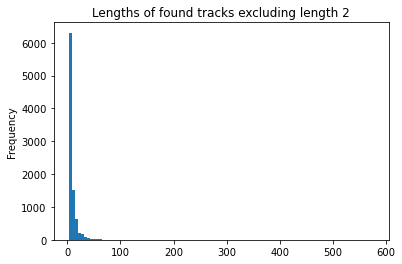

In [168]:
all_len = clust_df['all_ind_local'].apply(len)
all_len[all_len>2].plot.hist(bins=100)
plt.title('Lengths of found tracks (excluding length 2)')

In [149]:
clust_df

,clust_ind,all_ind_local,all_ind_global,all_xyz,slice_ind,extended_this_slice,not_finished,colors
0,0,"[5, 6]","[5, 148]","[[7.5, 513.4677276611328, 98.7389030456543], [...","[0, 1]",False,False,"[0.12156862745098039, 0.4666666666666667, 0.70..."
1,1,"[6, 2, 11, 12, 12, 23, 5, 7, 6, 10, 5, 7, 54, ...","[6, 144, 293, 436, 575, 725, 850, 989, 1119, 1...","[[10.0, 508.24971424449575, 103.97156108509411...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,"[0.12156862745098039, 0.4666666666666667, 0.70..."
2,2,"[8, 35, 37]","[8, 177, 319]","[[9.0, 384.00681559244794, 229.6750233968099],...","[0, 1, 2]",False,False,"[0.12156862745098039, 0.4666666666666667, 0.70..."
3,3,"[11, 15, 3, 21, 11, 3, 13, 18, 23, 11, 12, 11,...","[11, 157, 285, 445, 574, 705, 858, 1000, 1136,...","[[9.5, 411.021183013916, 311.0642318725586], [...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,"[0.12156862745098039, 0.4666666666666667, 0.70..."
4,4,"[12, 12, 2, 1, 9, 17, 28, 22, 18, 12, 8, 17, 15]","[12, 154, 284, 425, 572, 719, 873, 1004, 1131,...","[[8.5, 418.8942362467448, 267.5903727213542], ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",False,False,"[0.12156862745098039, 0.4666666666666667, 0.70..."
...,...,...,...,...,...,...,...,...
13426,13426,"[69, 69]","[136041, 136168]","[[19.0, 404.9707530628551, 354.6851834383878],...","[998, 999]",True,True,"[0.6196078431372549, 0.8549019607843137, 0.898..."
13427,13427,"[74, 83]","[136046, 136182]","[[18.5, 442.26753997802734, 153.6902256011963]...","[998, 999]",True,True,"[0.6196078431372549, 0.8549019607843137, 0.898..."
13428,13428,"[89, 110]","[136061, 136209]","[[22.0, 426.085700141059, 255.0216996934679], ...","[998, 999]",True,True,"[0.6196078431372549, 0.8549019607843137, 0.898..."
13429,13429,"[96, 112]","[136068, 136211]","[[22.0, 392.5264456612723, 382.9610290527344],...","[998, 999]",True,True,"[0.6196078431372549, 0.8549019607843137, 0.898..."
